In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install deepinv
!pip install odl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 641.9/641.9 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 114.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import os
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
from skimage import data
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
import json
import deepinv as dinv
from skimage.transform import iradon
from torch.utils.data import Dataset, DataLoader
from torch import Tensor
from itertools import repeat
import odl
from odl.phantom import ellipsoid_phantom
from odl import uniform_discr


In [4]:
from typing import Tuple, Union, Iterator
from itertools import repeat

class EllipsesDataset(torch.utils.data.Dataset):
    def __init__(self, shape=(256,256), length=5000, fixed_seed=42, fold="train"):
        self.shape = shape
        self.length = length
        self.max_n_ellipse = 70
        self.rng = np.random.RandomState(fixed_seed + (1 if fold=="validation" else 0))
        self._precompute_ellipses()
        self.space = odl.uniform_discr([-shape[0]/2, -shape[1]/2],
                                       [shape[0]/2,  shape[1]/2],
                                       shape)
    def _precompute_ellipses(self):
        self.ellipses_data = []
        for _ in range(self.length):
            v  = self.rng.uniform(-0.4, 1.0, self.max_n_ellipse)
            a1 = 0.2 * self.rng.exponential(1.0, self.max_n_ellipse)
            a2 = 0.2 * self.rng.exponential(1.0, self.max_n_ellipse)
            x  = self.rng.uniform(-0.9, 0.9, self.max_n_ellipse)
            y  = self.rng.uniform(-0.9, 0.9, self.max_n_ellipse)
            rot= self.rng.uniform(0, 2*np.pi, self.max_n_ellipse)
            n_ell = min(self.rng.poisson(self.max_n_ellipse), self.max_n_ellipse)
            v[n_ell:] = 0
            self.ellipses_data.append(np.stack([v, a1, a2, x, y, rot], axis=1))
    def __len__(self):
        return self.length
    def __getitem__(self, idx):
        ell = self.ellipses_data[idx]
        img_odl = ellipsoid_phantom(self.space, ell)      # ODL space element
        arr = img_odl.asarray()                           # now a NumPy array, shape (H,W)
        # normalize foreground to [0,1]
        mask = (arr != 0)
        if mask.any():
            arr[mask] = (arr[mask] - arr[mask].min()) / (arr[mask].max() - arr[mask].min())
        else:
            arr[:] = 0.0
        return torch.from_numpy(arr[None]).float()        # [1,H,W]


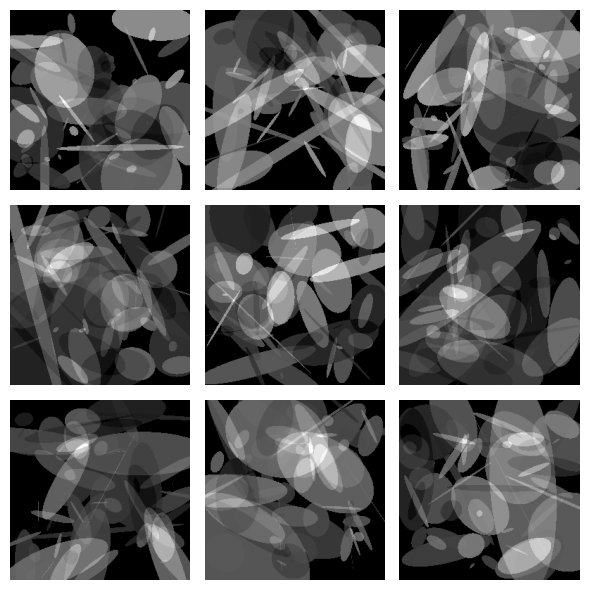

In [5]:
ds = EllipsesDataset(shape=(256,256), length=16, fixed_seed=42, fold="train")

# 2) Grab the first N images
imgs = []
for i in range(9):
    img = ds[i]             # this is a torch tensor [1,H,W]
    imgs.append(img.squeeze(0).numpy())

# 3) Plot them in a 3×3 grid
fig, axs = plt.subplots(3, 3, figsize=(6,6))
for ax, im in zip(axs.flat, imgs):
    ax.imshow(im, cmap="gray", vmin=0, vmax=1)
    ax.axis("off")
plt.tight_layout()
plt.show()

def save_img(out_put_tensor, epoch, out_dir="outputs"):
  """
  Save the image output at each epoch
  """
  img = out_put_tensor.squeeze().detach.cpu().numpy()

  os.makedirs(out_dir, exist_ok = True)
  name = f"output_{epoch}"
  plt.imsave(os.path.join(out_dir, name), img, cmap="gray", vmin=0, vmax=1)





In [6]:
# Import UNet file
sys.path.append('/content/drive/MyDrive/MScProject')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from Model_arch import UNet


# Import Elipses Data
train_ds = EllipsesDataset(shape=(256,256), length=5000, fixed_seed=42, fold="train")
test_ds  = EllipsesDataset(shape=(256,256), length=1000, fixed_seed=42, fold="validation")

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=64)

In [7]:
class OperatorFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, operator, x):
        # ctx.operator saved for backward
        ctx.operator = operator
        # call the DeepInv forward operator A
        with torch.no_grad():
            out = operator.A(x)
        # no need to save x unless A is nonlinear
        return out

    @staticmethod
    def backward(ctx, grad_output):
        # in the backward pass, apply the adjoint A_adjoint
        operator = ctx.operator
        grad_input = operator.A_adjoint(grad_output)
        # first returned None says “no gradient for operator”
        return None, grad_input

class OperatorModule(torch.nn.Module):
    def __init__(self, operator):
        super().__init__()
        self.operator = operator

    def forward(self, x):
        # call our custom Function
        return OperatorFunction.apply(self.operator, x)

    def A_dagger(self, y):
        # if you ever want to call the adjoint directly
        return self.operator.A_adjoint(y)

In [8]:
angles_torch = torch.linspace(0,180,60,device=device)

angles_torch = torch.linspace(0,180,60,device=device)
physics_raw = dinv.physics.Tomography(
    img_width=256, angles=angles_torch, device=device,
    noise_model=dinv.physics.GaussianNoise(sigma=0.02)
)

physics = OperatorModule(physics_raw)

In [9]:
pre_model = UNet(1, 1)
pre_model = pre_model.to(device)
opt = torch.optim.Adam(pre_model.parameters(), lr = 1e-4)

Epoch 00 train MSE: 2184.7178
Best model saved at epoch 0


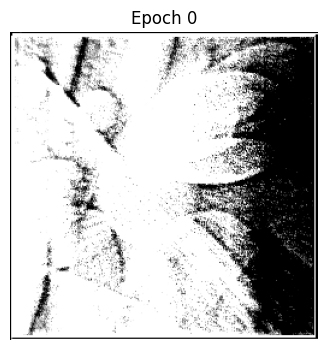

Epoch 00 test  MSE: 13.5876
Epoch 01 train MSE: 10.2031
Best model saved at epoch 1


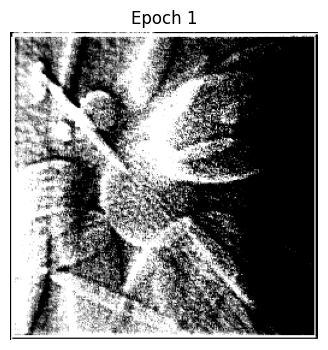

Epoch 01 test  MSE: 7.5061
Epoch 02 train MSE: 5.8052
Best model saved at epoch 2


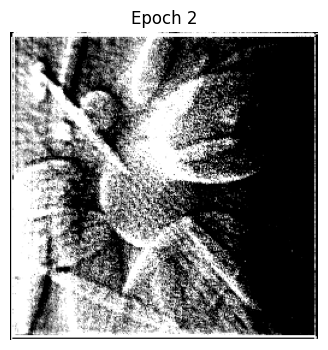

Epoch 02 test  MSE: 4.3123
Epoch 03 train MSE: 3.3218
Best model saved at epoch 3


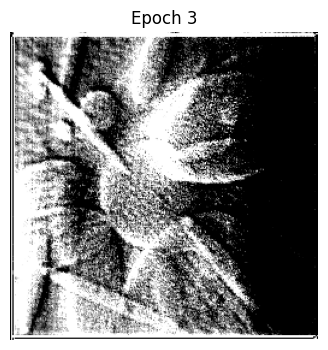

Epoch 03 test  MSE: 2.4976
Epoch 04 train MSE: 1.9692
Best model saved at epoch 4


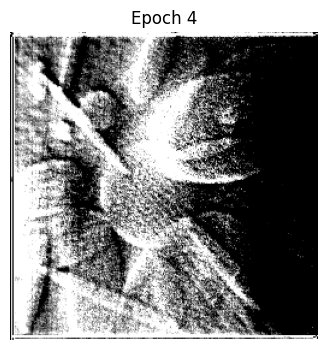

Epoch 04 test  MSE: 1.5321
Epoch 05 train MSE: 1.2731
Best model saved at epoch 5


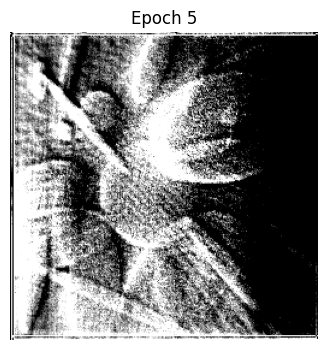

Epoch 05 test  MSE: 1.0587
Epoch 06 train MSE: 0.9312
Best model saved at epoch 6


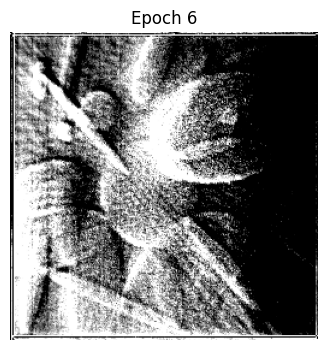

Epoch 06 test  MSE: 0.8273
Epoch 07 train MSE: 0.7560
Best model saved at epoch 7


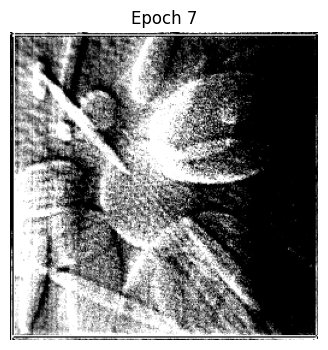

Epoch 07 test  MSE: 0.6907
Epoch 08 train MSE: 0.6403
Best model saved at epoch 8


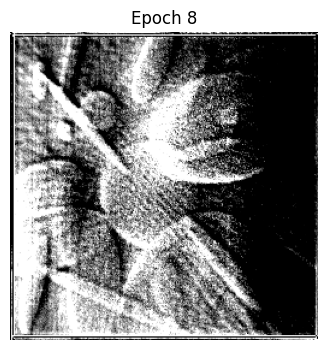

Epoch 08 test  MSE: 0.5931
Epoch 09 train MSE: 0.5554
Best model saved at epoch 9


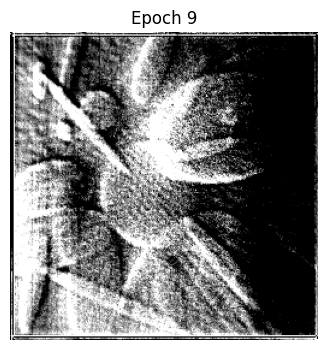

Epoch 09 test  MSE: 0.5188
Epoch 10 train MSE: 0.4896
Best model saved at epoch 10


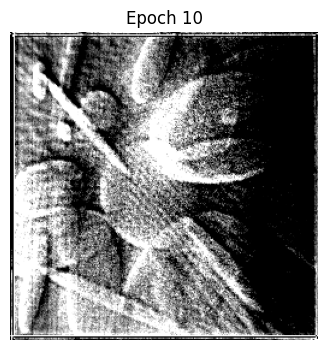

Epoch 10 test  MSE: 0.4598
Epoch 11 train MSE: 0.4349
Best model saved at epoch 11


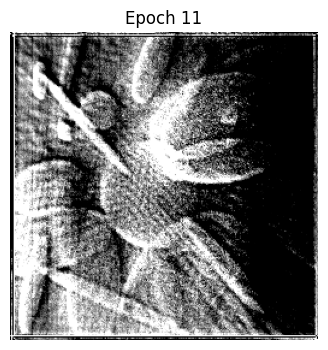

Epoch 11 test  MSE: 0.4083
Epoch 12 train MSE: 0.2910
Best model saved at epoch 12


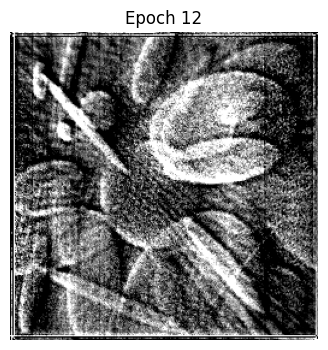

Epoch 12 test  MSE: 0.2139
Epoch 13 train MSE: 0.1717
Best model saved at epoch 13


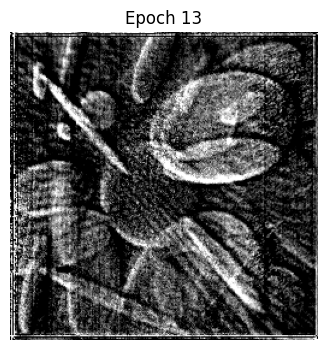

Epoch 13 test  MSE: 0.1496
Epoch 14 train MSE: 0.1370
Best model saved at epoch 14


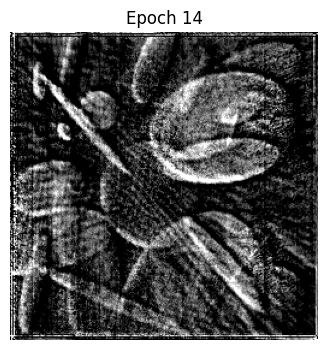

Epoch 14 test  MSE: 0.1372
Epoch 15 train MSE: 0.1238
Best model saved at epoch 15


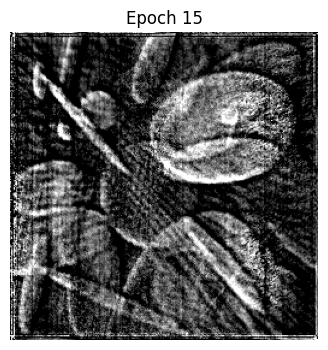

Epoch 15 test  MSE: 0.1197
Epoch 16 train MSE: 0.1163
Best model saved at epoch 16


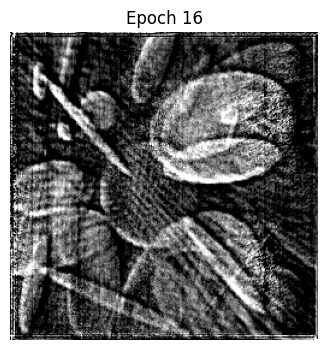

Epoch 16 test  MSE: 0.1115
Epoch 17 train MSE: 0.1099
Best model saved at epoch 17


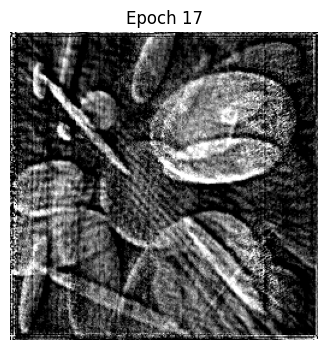

Epoch 17 test  MSE: 0.1054
Epoch 18 train MSE: 0.1016


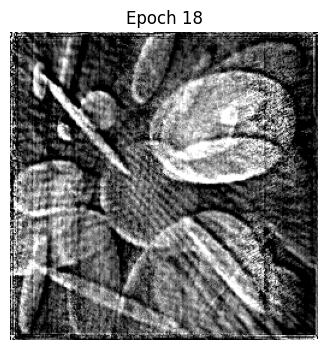

Epoch 18 test  MSE: 0.1061
Epoch 19 train MSE: 0.0928
Best model saved at epoch 19


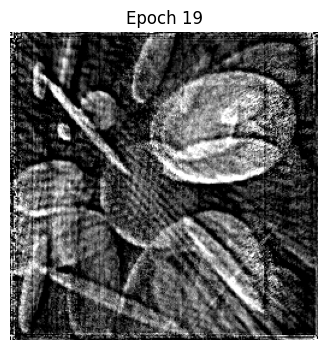

Epoch 19 test  MSE: 0.0878


In [10]:
epochs = 20
loss_fn = torch.nn.MSELoss()

# Save Weights

os.makedirs('/content/drive/MyDrive/MScProject/checkpoints', exist_ok=True)
best_test_loss = float('inf')

for epoch in range(epochs):
    pre_model.train()
    running = 0.0
    for x_true in train_loader:              # now x_true is [B,1,256,256]
      x_true = x_true.to(device)
      y = physics(x_true)             # forward project → [B,1,det,angles]
      x0 = physics.A_dagger(y)         # back-project → [B,1,256,256]
      y_pred = pre_model(x0)               # refine in image space
      loss = loss_fn(y_pred, x_true)
      loss.backward()
      opt.step()
      opt.zero_grad()
      running += loss.item()
    print(f"Epoch {epoch:02d} train MSE: {running/len(train_loader):.4f}")

    pre_model.eval()
    pre_model.train()
    running_test = 0.0
    with torch.no_grad():
      for x_true in test_loader:              # now x_true is [B,1,256,256]
        x_true = x_true.to(device)
        y = physics(x_true)             # forward project → [B,1,det,angles]
        x0 = physics.A_dagger(y)         # back-project → [B,1,256,256]
        y_pred = pre_model(x0)               # refine in image space
        loss   = loss_fn(y_pred, x_true)
        running_test += loss.item()
    # y_pred is [B, 1, H, W]; let's grab the first sample and first channel
    if running_test < best_test_loss:
      best_test_loss = running_test
      torch.save(pre_model.state_dict(), '/content/drive/MyDrive/MScProject/checkpoints/pre_model.pth')
      print(f"Best model saved at epoch {epoch}")
    img = y_pred[0, 0].detach().cpu().numpy()   # shape (256,256)
    plt.figure(figsize=(4,4))
    plt.imshow(img, cmap="gray", vmin=0, vmax=1)
    plt.axis("off")
    plt.title(f"Epoch {epoch}")
    plt.show()
    print(f"Epoch {epoch:02d} test  MSE: {running_test/len(test_loader):.4f}")


In [11]:
from google.colab import files
print("Download pre_model.pth")
files.download("/content/drive/MyDrive/MScProject/checkpoints/pre_model.pth")

Download pre_model.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>